Testing standard keras transformers

Following https://keras.io/examples/structured_data/tabtransformer/

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from functools import partial
from aiproteomics.tfrecords import get_dataset
import matplotlib.pyplot as plt
from pathlib import Path
from aiproteomics.modelgen.prosit1.losses import masked_spectral_distance
import wandb
from wandb.integration.keras import WandbMetricsLogger
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

2024-10-31 15:52:31.272338: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-31 15:52:31.307019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 15:52:31.307044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 15:52:31.307965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 15:52:31.313214: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-31 15:52:31.313642: I tensorflow/core/platform/cpu_feature_guard.cc:1

Number of replicas: 1


In [2]:
AUTOTUNE = tf.data.AUTOTUNE
DATAPATH = Path("../data")
SAMPLE_FILE = DATAPATH/"randomized-0.tfrecord"
BATCH_SIZE = 64
VOCABULARY_SIZE = 30
SEQUENCE_LENGTH = 50
OUTPUT_SHAPE = 392

In [3]:
TRAINING_FILENAMES = VALID_FILENAMES = TEST_FILENAMES = [SAMPLE_FILE.resolve()]

print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

Train TFRecord Files: 1
Validation TFRecord Files: 1
Test TFRecord Files: 1


In [4]:
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_dataset(TEST_FILENAMES)

train_dataset

This is what an example looks like: Tensor("args_0:0", shape=(), dtype=string)
Parsed example: {'charge': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=(1,) dtype=int64>, 'msms': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:1' shape=(392,) dtype=float32>, 'pep': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:2' shape=(50,) dtype=int64>}
This is what an example looks like: Tensor("args_0:0", shape=(), dtype=string)
Parsed example: {'charge': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=(1,) dtype=int64>, 'msms': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:1' shape=(392,) dtype=float32>, 'pep': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:2' shape=(50,) dtype=int64>}
This is what an example looks like: Tensor("args_0:0", shape=(), dtype=string)
Parsed example: {'charge': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=(1,) dtype=int64>, 'msms': <tf.Tensor 'ParseSingleEx

<_BatchDataset element_spec=({'charge': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), 'pep': TensorSpec(shape=(None, 50), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 392), dtype=tf.float32, name=None))>

In [5]:
train_dataset.element_spec

({'charge': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None),
  'pep': TensorSpec(shape=(None, 50), dtype=tf.int32, name=None)},
 TensorSpec(shape=(None, 392), dtype=tf.float32, name=None))

In [6]:
NUMERICAL_FEATURES = ["charge"]
CATEGORICAL_FEATURES = {"pep": list(range(VOCABULARY_SIZE))}
TARGET_FEATURE_NAME = "msms"
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES.keys())

In [7]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 265
NUM_EPOCHS = 15

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

In [8]:
def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    # Set up wandb

    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="aiproteomics",
    
        # track hyperparameters and run metadata
        config={
        "model": model.name
        "num_epochs": num_epochs,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        }
    )

    model.compile(
        optimizer=optimizer,
        loss=masked_spectral_distance,
        metrics=[masked_spectral_distance],
    )

    train_dataset = get_dataset(train_data_file)
    validation_dataset = get_dataset(train_data_file)

    print("Start training the model...")
    history = model.fit(
        train_dataset, 
        epochs=num_epochs,
        validation_data=validation_dataset,
        callbacks=[WandbMetricsLogger()]
        
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history

In [35]:
def create_model_inputs():
    # Inputs
    charge_input = layers.Input(
                name="charge", dtype="float32", batch_input_shape=(None, 1)
            )
    peptides = layers.Input(
                name="pep", dtype="int32", batch_input_shape=(None, SEQUENCE_LENGTH)
            )
    return {"charge": charge_input, "pep": peptides}

def encode_inputs(inputs, embedding_dims, vocabulary_size=VOCABULARY_SIZE, expand_charge=False):
    # Encoding
    embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=embedding_dims)
    
    pep_embedding = embedding(inputs["pep"])
    charge_feature = inputs["charge"]
    
    if expand_charge:
        charge_feature = tf.expand_dims(charge_feature, -1)
        charge_feature = tf.repeat(charge_feature, EMBEDDING_DIMS, axis=2)
        print(f"Charge repeated: {charge_feature}")
    
    return charge_feature, pep_embedding


def create_mlp(hidden_units,
                activation,
                normalization_layer,
                dropout_rate,
                name=None):
    mlp_layers = []
    
    for units in hidden_units:
        mlp_layers.append(normalization_layer())
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))
    
    mlp = keras.Sequential(mlp_layers, name=name)
    
    return mlp



Charge repeated: KerasTensor(type_spec=TensorSpec(shape=(None, 1, 16), dtype=tf.float32, name=None), name='tf.repeat_11/Repeat/Reshape_1:0', description="created by layer 'tf.repeat_11'")
Total model weights: 16086584


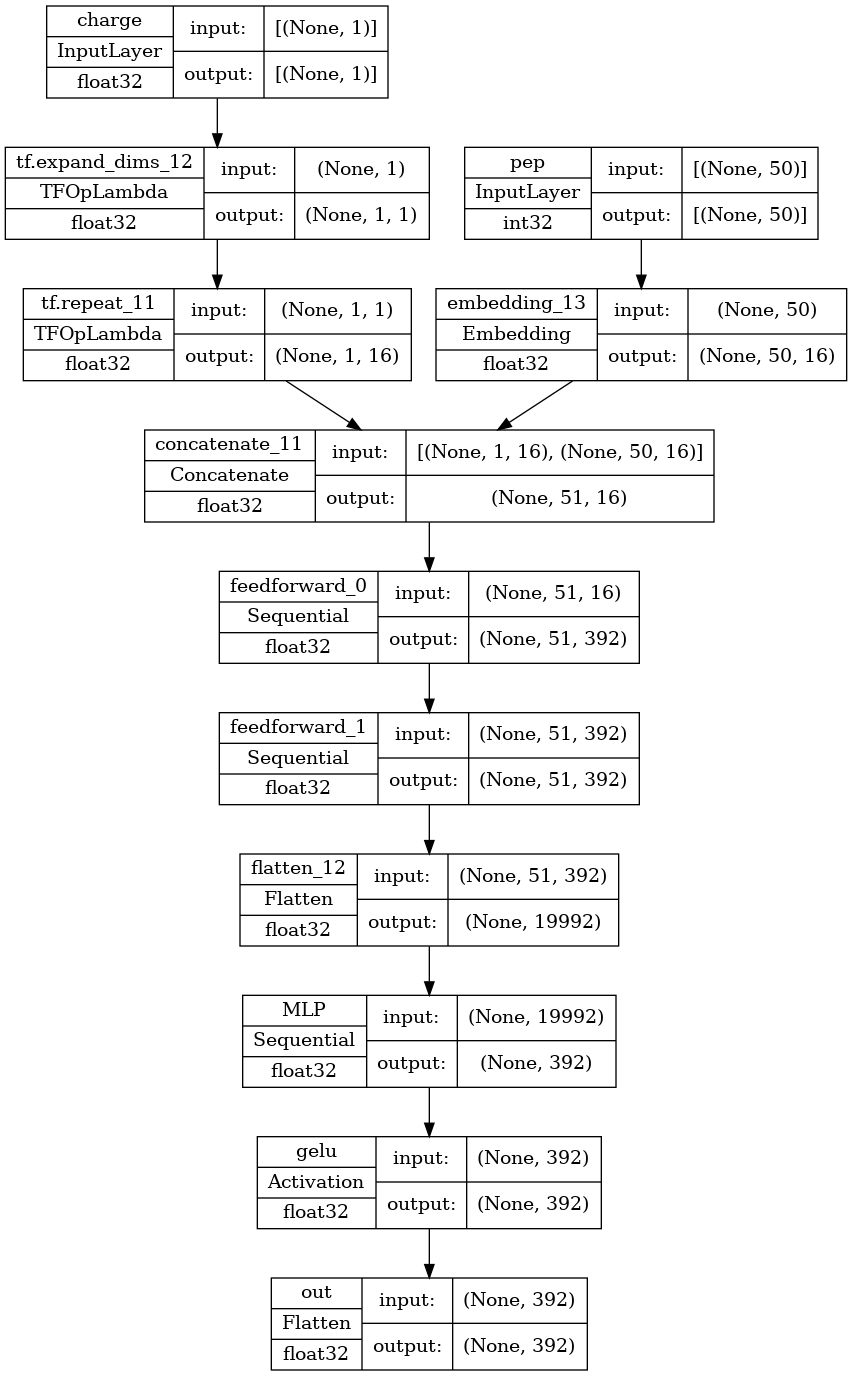

In [36]:
# Baseline model without transformer

def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):
    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    charge_feature, encoded_pep = encode_inputs(
        inputs, embedding_dims, expand_charge=True
    )

    features = layers.concatenate([charge_feature, encoded_pep], axis=1)
    
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1], OUTPUT_SHAPE]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization,
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    
    # Flatten everything
    features = layers.Flatten()(features)
    
    # Create final MLP.
    mlp = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization,
        name="MLP",
    )(features)
    
    activation = layers.Activation(tf.keras.activations.gelu, name='gelu', trainable=True)(mlp)

    output_layer = layers.Flatten(
        name='out', data_format='channels_last', trainable=True)(activation)
    
    
    model = keras.Model(inputs=inputs, outputs=output_layer, name="baseline")
    return model


baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)
print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="TB", show_dtype=True)

In [37]:
run_experiment(baseline_model,TRAINING_FILENAMES, TEST_FILENAMES, NUM_EPOCHS, LEARNING_RATE, WEIGHT_DECAY, BATCH_SIZE)

wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

Total model weights: 2897957


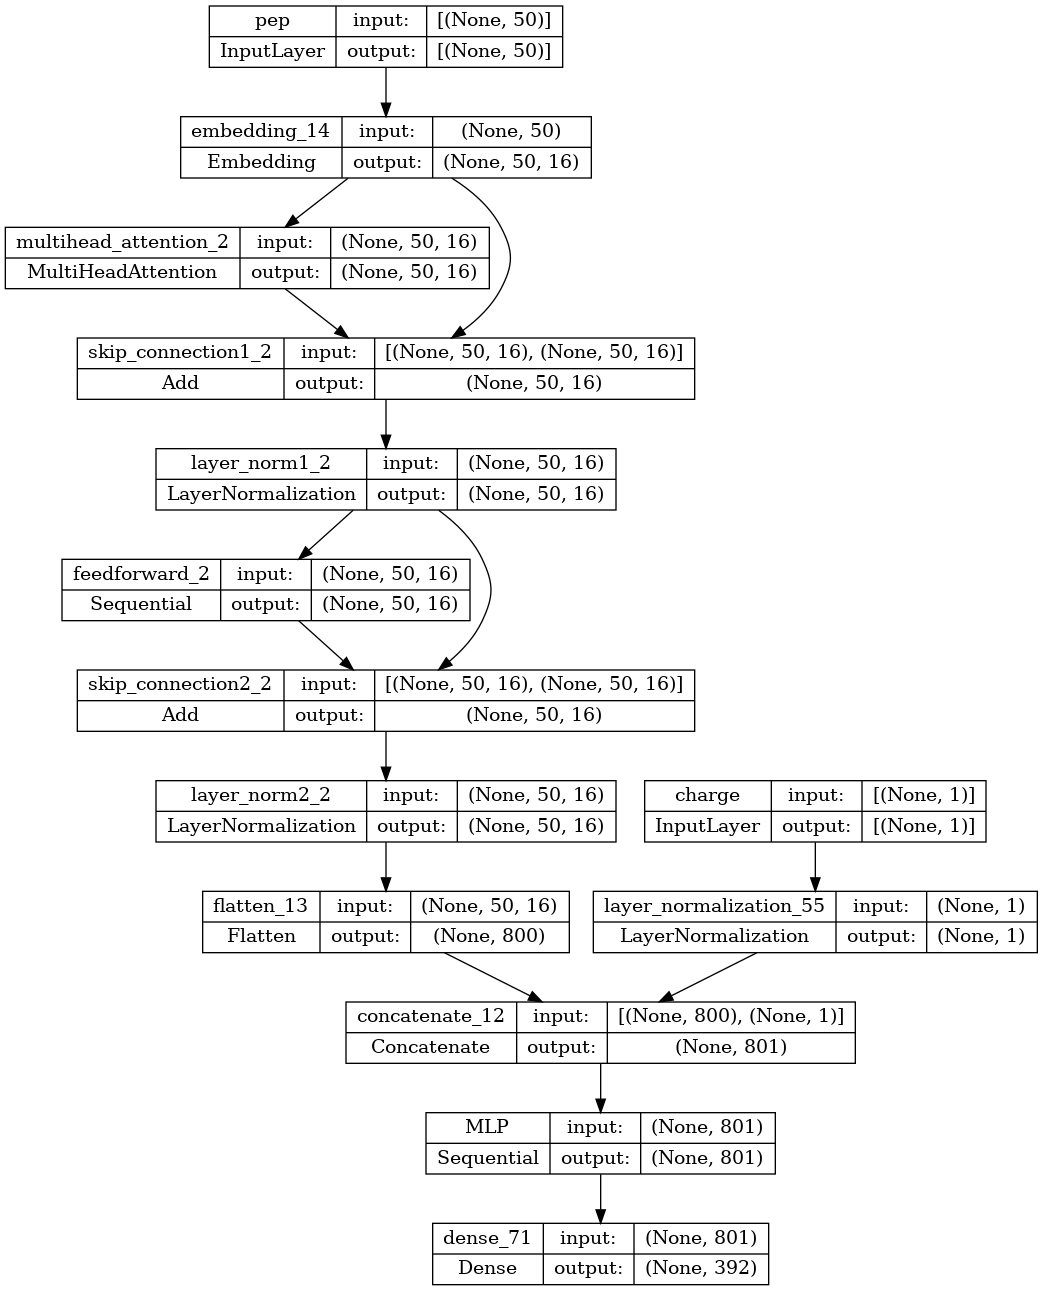

In [38]:
def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    output_shape
):
    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    charge_feature, pep_embedding = encode_inputs(inputs, embedding_dims)
    

    # Tutorial does column embedding for multiple categorical features,
    # but we only have one categorical feature so I'm skipping that
    # Add column embedding to categorical feature embeddings.
    
    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(pep_embedding, pep_embedding)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, pep_embedding]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=partial(
                layers.LayerNormalization, epsilon=1e-6
            ),  # using partial to provide keyword arguments before initialization
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        pep_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    pep_features = layers.Flatten()(pep_features)
    # Apply layer normalization to the numerical features.
    charge_feature = layers.LayerNormalization(epsilon=1e-6)(charge_feature)
    
    # Prepare the input for the final MLP block.
    features = layers.concatenate([pep_features, charge_feature])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization,
        name="MLP",
    )(features)

    outputs = layers.Dense(units=output_shape)(features)
    model = keras.Model(inputs=inputs, outputs=outputs, name="tabtransformer")
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
    output_shape=OUTPUT_SHAPE
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="TB")

In [39]:
run_experiment(tabtransformer_model,TRAINING_FILENAMES, TEST_FILENAMES, NUM_EPOCHS, LEARNING_RATE, WEIGHT_DECAY, BATCH_SIZE)

This is what an example looks like: Tensor("args_0:0", shape=(), dtype=string)
Parsed example: {'charge': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=(1,) dtype=int64>, 'msms': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:1' shape=(392,) dtype=float32>, 'pep': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:2' shape=(50,) dtype=int64>}
This is what an example looks like: Tensor("args_0:0", shape=(), dtype=string)
Parsed example: {'charge': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=(1,) dtype=int64>, 'msms': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:1' shape=(392,) dtype=float32>, 'pep': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:2' shape=(50,) dtype=int64>}
Start training the model...
Epoch 1/15
    382/Unknown - 26s 60ms/step - loss: 0.2745 - masked_spectral_distance: 0.2745

KeyboardInterrupt: 